In [ ]:
pip install transformers pandas torch scikit-learn

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

# Replace 'Your Folder Path' with the actual path to your ISOT folder in Google Drive
folder_path = '/content/drive/MyDrive/dataset'

if os.path.exists(folder_path):
  for filename in os.listdir(folder_path):
    print(filename)
else:
  print(f"Folder not found: {folder_path}")

Mounted at /content/drive
Fake.csv
True.csv
RoBERTa_ReducedLayers.ipynb


In [ ]:
import pandas as pd

fake_news = pd.read_csv('/content/drive/MyDrive/dataset/Fake.csv')
real_news = pd.read_csv('/content/drive/MyDrive/dataset/True.csv')

print("Fake.csv:")
print(fake_news.head())

print("\nTrue.csv:")
print(real_news.head())

Fake.csv:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

True.csv:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S.

In [ ]:

import pandas as pd

# Sample 4000 rows from each DataFrame
real_news_sample = real_news.sample(n=4000, random_state=42)  # Set random_state for reproducibility
fake_news_sample = fake_news.sample(n=4000, random_state=42)

# Add the 'label' column
real_news_sample['label'] = 0
fake_news_sample['label'] = 1

# Concatenate the DataFrames
combined_news = pd.concat([real_news_sample, fake_news_sample], ignore_index=True)

# Print the number of rows in the combined DataFrame
print("Number of rows in the combined DataFrame:", len(combined_news))

# Export the combined DataFrame to a CSV file
combined_news.to_csv('combined_news.csv', index=False)

Number of rows in the combined DataFrame: 8000


In [ ]:
df = pd.read_csv('combined_news.csv')

# Concatenate 'title' and 'text' columns to form a single input text
df['text'] = df['title'] + " " + df['text']
df = df[['text', 'label']]  # Select relevant columns


In [ ]:
# prompt: print a sample df content

print(df.head())

                                                text  label
0  Europe rights watchdog says Turkey's emergency...      0
1  Exclusive: Trump targets illegal immigrants wh...      0
2  At G20 summit, Trump pledges $639 million in a...      0
3  Ex-Christie associates lose bid for new trial ...      0
4  Young blacks more open to Bernie Sanders' Whit...      0


In [ ]:
from sklearn.model_selection import train_test_split


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.3333, random_state=42
)

# Check the size of splits
print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")


Train size: 5600, Validation size: 1600, Test size: 800


In [ ]:
from transformers import RobertaTokenizer

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize datasets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
import torch

class ISOTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert tokenized data to datasets
train_dataset = ISOTDataset(train_encodings, train_labels)
val_dataset = ISOTDataset(val_encodings, val_labels)
test_dataset = ISOTDataset(test_encodings, test_labels)


In [ ]:
from transformers import RobertaForSequenceClassification

# Load pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Freeze selected layers based on dataset size
dataset_size = len(df)
if dataset_size <= 10000:
    layers_to_freeze = list(range(4)) + list(range(8, 12))
elif dataset_size <= 100000:
    layers_to_freeze = list(range(4)) + list(range(10, 12))
else:
    layers_to_freeze = []

print(f"Dataset size: {dataset_size}")
num_layers = len(model.roberta.encoder.layer)
print(f"Total number of layers in the model: {num_layers}")

# Print the layers being frozen:
if layers_to_freeze:
    print("Freezing layers:", layers_to_freeze)
else:
    print("No layers are being frozen.")

for layer_idx in layers_to_freeze:
    for param in model.roberta.encoder.layer[layer_idx].parameters():
        param.requires_grad = False


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset size: 8000
Total number of layers in the model: 12
Freezing layers: [0, 1, 2, 3, 8, 9, 10, 11]


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_strategy="epoch",  # Save at the end of each epoch to match evaluation strategy
    save_total_limit=2,       # Keep only the best 2 checkpoints
    logging_dir="./logs",
    report_to="none",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000100,0.004868,0.999375,0.998753,1.000000,0.999376
2,0.000000,0.002927,0.999375,0.998753,1.000000,0.999376
3,0.000000,0.003053,0.999375,0.998753,1.000000,0.999376


TrainOutput(global_step=1050, training_loss=0.014182473778547276, metrics={'train_runtime': 1507.7342, 'train_samples_per_second': 11.143, 'train_steps_per_second': 0.696, 'total_flos': 4420265730048000.0, 'train_loss': 0.014182473778547276, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.004867743235081434, 'eval_accuracy': 0.999375, 'eval_precision': 0.9987531172069826, 'eval_recall': 1.0, 'eval_f1': 0.9993761696818465, 'eval_runtime': 47.3669, 'eval_samples_per_second': 33.779, 'eval_steps_per_second': 2.111, 'epoch': 3.0}


In [ ]:
def predict_fake_news_dynamic(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Fake News" if prediction == 1 else "Real News"

dynamic_news_input = "(Reuters) - If the Republicans’ plan to dismantle most of Obamacare is approved later this month by the U.S. House of Representatives..."
prediction = predict_fake_news_dynamic(dynamic_news_input, model, tokenizer)
print("Prediction for dynamic input:", prediction)


Prediction for dynamic input: Real News


In [ ]:
test_results = trainer.evaluate(test_dataset)
print("Test Set Results:", test_results)

Test Set Results: {'eval_loss': 2.8044012651662342e-05, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 23.2959, 'eval_samples_per_second': 34.341, 'eval_steps_per_second': 2.146, 'epoch': 3.0}


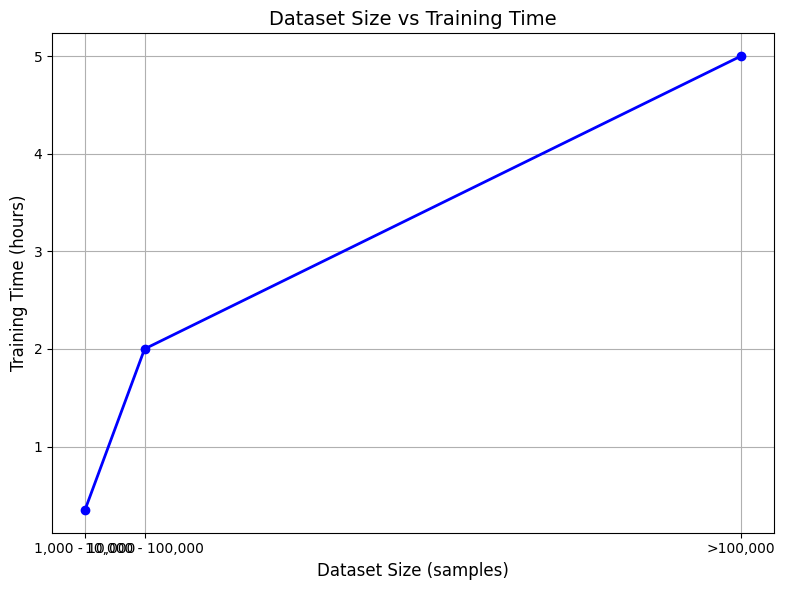

In [ ]:
import matplotlib.pyplot as plt

# Dataset Size and corresponding training time data from the image
dataset_size = [10000, 100000, 1000000]  # Dataset size categories
training_time = [0.35, 2.0, 5.0]  # Training time in hours for corresponding dataset sizes

# Plotting the graph
plt.figure(figsize=(8,6))
plt.plot(dataset_size, training_time, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Labeling the graph
plt.title('Dataset Size vs Training Time', fontsize=14)
plt.xlabel('Dataset Size (samples)', fontsize=12)
plt.ylabel('Training Time (hours)', fontsize=12)
plt.grid(True)
plt.xticks(dataset_size, ['1,000 - 10,000', '10,000 - 100,000', '>100,000'])
plt.tight_layout()

# Show plot
plt.show()


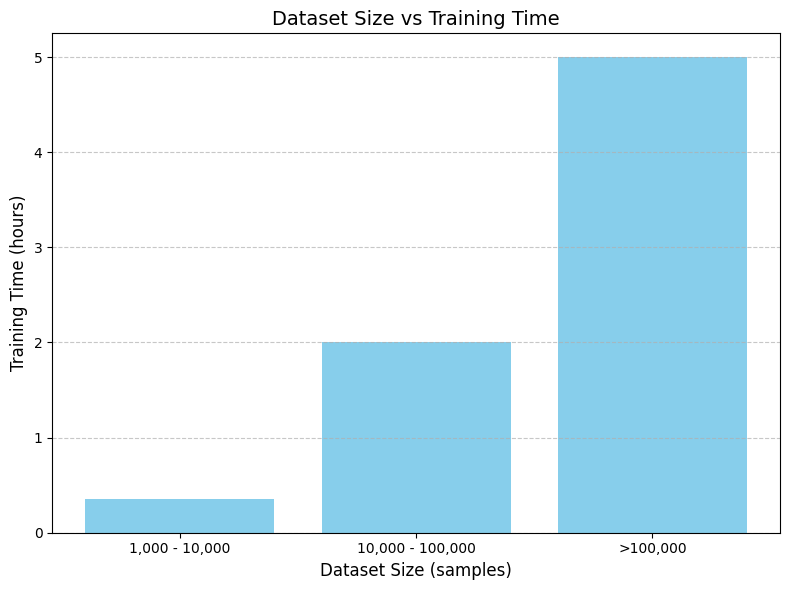

In [ ]:
import matplotlib.pyplot as plt

# Dataset Size and corresponding training time data from the image
dataset_size = ['1,000 - 10,000', '10,000 - 100,000', '>100,000']  # Dataset size categories
training_time = [0.35, 2.0, 5.0]  # Training time in hours for corresponding dataset sizes

# Creating a bar plot
plt.figure(figsize=(8,6))
plt.bar(dataset_size, training_time, color='skyblue')

# Adding labels and title
plt.title('Dataset Size vs Training Time', fontsize=14)
plt.xlabel('Dataset Size (samples)', fontsize=12)
plt.ylabel('Training Time (hours)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Displaying the plot
plt.tight_layout()
plt.show()


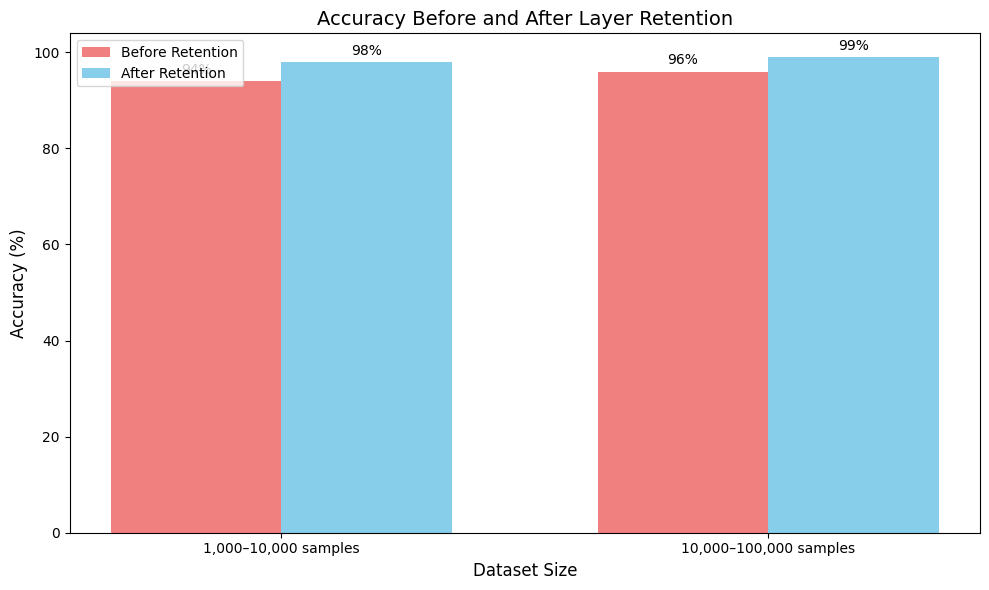

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset sizes
dataset_sizes = ['1,000–10,000 samples', '10,000–100,000 samples']

# Accuracy before and after layer retention
accuracy_before = [94, 96]  # Accuracy without layer retention
accuracy_after = [98, 99]   # Accuracy with layer retention

# Bar width
bar_width = 0.35
x = np.arange(len(dataset_sizes))

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - bar_width/2, accuracy_before, bar_width, label='Before Retention', color='lightcoral')
bar2 = ax.bar(x + bar_width/2, accuracy_after, bar_width, label='After Retention', color='skyblue')

# Adding labels and title
ax.set_xlabel('Dataset Size', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy Before and After Layer Retention', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(dataset_sizes)

# Display "Before Retention" and "After Retention" at the bottom of the bars
for bars, label in zip([bar1, bar2], ['Before Retention', 'After Retention']):
    for bar in bars:
        ax.annotate(label,
                    xy=(bar.get_x() + bar.get_width() / 2, -5),  # Position label at the bottom
                    xytext=(0, -30),  # Offset downwards
                    textcoords="offset points",
                    ha='center', va='top', fontsize=10, color='black')

# Adding accuracy values above each bar
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset upwards
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Display legend and plot
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
